<a href="https://colab.research.google.com/github/djaramil/CEN5035-Elastic-Setup-Startup/blob/main/P3_yoda26_CAP6619_Summer2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAP 6619 - Deep Learning
## Dr Marques
## Project 3
## Image classification using the CIFAR-10 dataset

Total number of points: 100 (+ 15 optional bonus points), as indicated.

**Include your name here:** (enter your name)

**Include 'shared link' to 'your' final version of this NB here:** (enter link from above right here)

*Expand all notebook bocks/sections and ensure code has properly executed, save as pdf(above left menu) when completed to submit to Canvas.*

Useful references and sources:

https://www.kaggle.com/c/cifar-10

https://keras.io/examples/vision/metric_learning/

https://www.kaggle.com/roblexnana/cifar10-with-cnn-for-beginer


##### **Cite your sources** *(OPTIONAL if none used beyond those above)*

Add your own sources and references here.

# Part 1: Designing and using your own CNN model

## Part 1.1: Setup

### Import Needed Resources / Libraries

In [3]:
from __future__ import print_function
from tensorflow import keras
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import itertools

%matplotlib inline

import random

import tensorflow as tf
from collections import defaultdict
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay

### Load and prepare the data

In [10]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the image data
x_train = x_train.astype("float32") / 255.0
y_train = np.squeeze(y_train)
x_test = x_test.astype("float32") / 255.0
y_test = np.squeeze(y_test)

170498071/170498071 [==============================] - 6s 0us/step


## Part 1.2: Examine Data

In [11]:
# Number of samples
print("Number of training sample: ",y_train.shape[0])
print("Number of test samples: ", y_test.shape[0])

Number of training sample:  50000
Number of test samples:  10000


In [12]:
# Number of classes
num_classes = max(y_test)+1
print(num_classes)

10


In [13]:
# Shape of image data
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


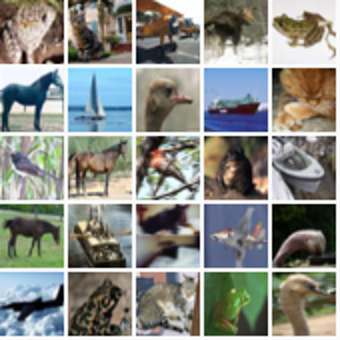

In [14]:
# Show collage of 25 (randomly selected) images

height_width = 32


def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows * box_size),
        color=(250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    # Double size for visualisation.
    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage


# Show a collage of 5x5 random images.
sample_idxs = np.random.randint(0, 50000, size=(5, 5))
examples = x_train[sample_idxs]
show_collage(examples)

In [15]:
idx = y_train[0]
print(idx)

6


In [16]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [17]:
labels[idx]

'Frog'

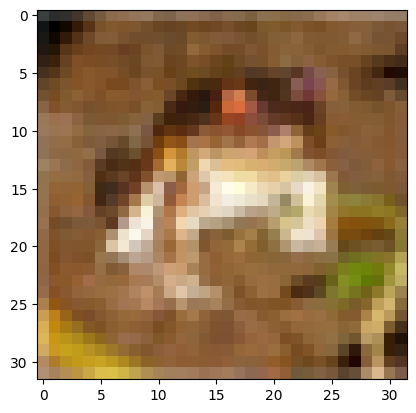

In [18]:
plt.imshow(x_train[0])

In [19]:
# Convert class vectors to binary class matrices.
# This is called one-hot encoding.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [20]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

## **Part 1.3: Design and configure model** *(CNN)*

In this part we will use a convolutional neural network (CNN) built from scratch.


In [21]:
batch_size = 128
epochs = 10
data_augmentation = False

In [22]:
#define the convnet
model = Sequential()
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTEN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# a softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                      

In [23]:
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## **Part 1.4: Train the model**

In [24]:
history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/10
391/391 [==============================] - 16s 16ms/step - loss: 1.9521 - accuracy: 0.2822 - val_loss: 1.7079 - val_accuracy: 0.3864
Epoch 2/10
391/391 [==============================] - 5s 14ms/step - loss: 1.6769 - accuracy: 0.3927 - val_loss: 1.5827 - val_accuracy: 0.4328
Epoch 3/10
391/391 [==============================] - 5s 14ms/step - loss: 1.5628 - accuracy: 0.4337 - val_loss: 1.4447 - val_accuracy: 0.4788
Epoch 4/10
391/391 [==============================] - 5s 14ms/step - loss: 1.4785 - accuracy: 0.4647 - val_loss: 1.3696 - val_accuracy: 0.5132
Epoch 5/10
391/391 [==============================] - 5s 13ms/step - loss: 1.4084 - accuracy: 0.4905 - val_loss: 1.4247 - val_accuracy: 0.4869
Epoch 6/10
391/391 [==============================] - 5s 14ms/step - loss: 1.3568 - accuracy: 0.5150 - val_loss: 1.2788 - val_accuracy: 0.5478
Epoch 7/10
391/391 [==============================] - 5s 14ms/step - loss: 1.3087 - accuracy: 0.5335 - val_loss: 1.2072 - val_accuracy: 0.574

In [25]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


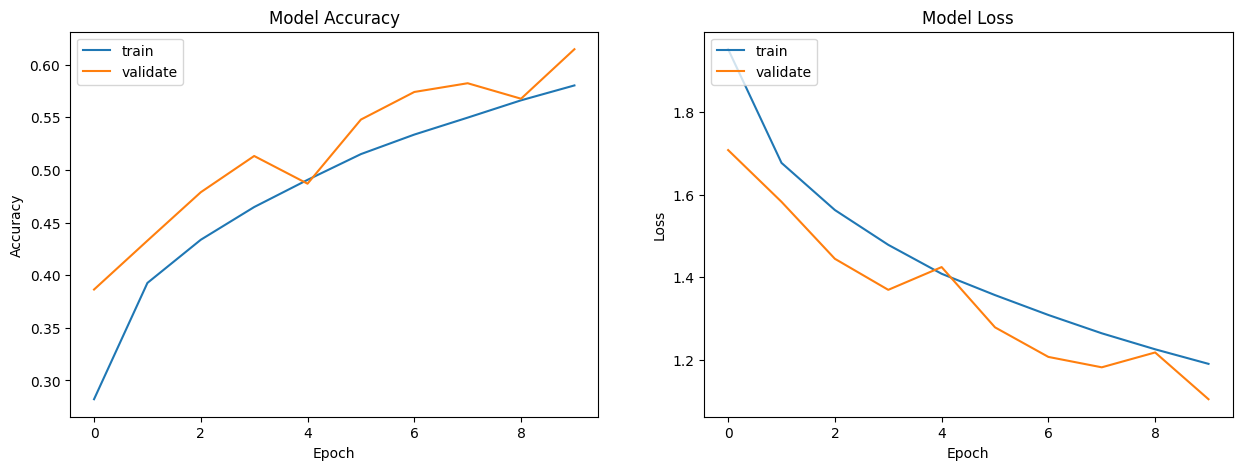

In [26]:
plotmodelhistory(history)

## **Part 1.5: Evaluate the model**

In [27]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.1047 - accuracy: 0.6146
Test loss: 1.1047474145889282
Test accuracy: 0.6146000027656555
313/313 [==============================] - 1s 2ms/step


In [28]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

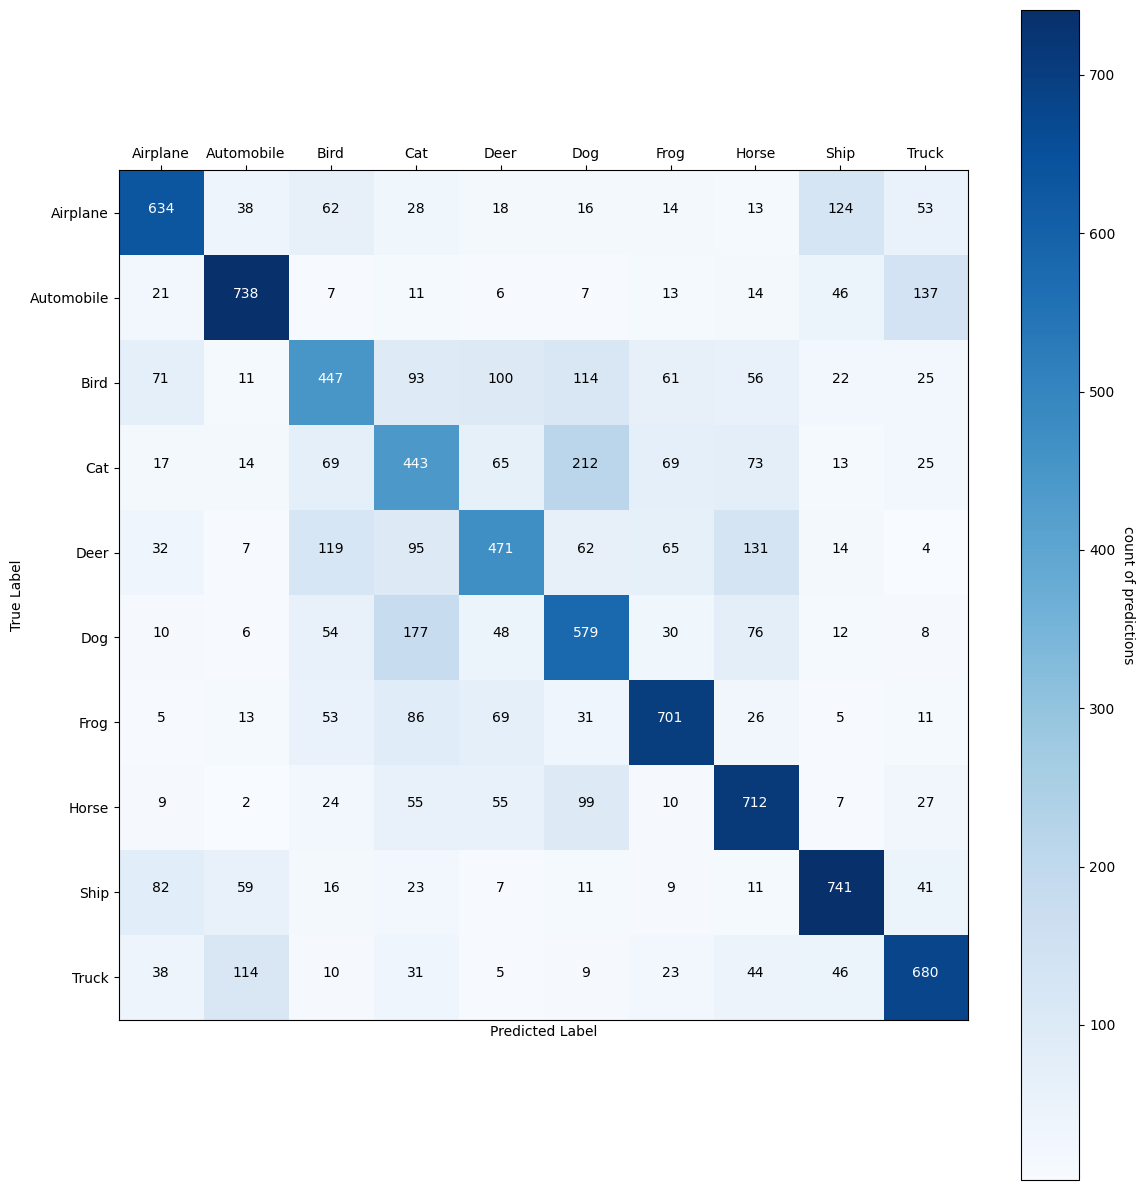

In [29]:
# Plot confusion matrix

# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes)
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

In [30]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.69      0.63      0.66      1000
           1       0.74      0.74      0.74      1000
           2       0.52      0.45      0.48      1000
           3       0.43      0.44      0.43      1000
           4       0.56      0.47      0.51      1000
           5       0.51      0.58      0.54      1000
           6       0.70      0.70      0.70      1000
           7       0.62      0.71      0.66      1000
           8       0.72      0.74      0.73      1000
           9       0.67      0.68      0.68      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000



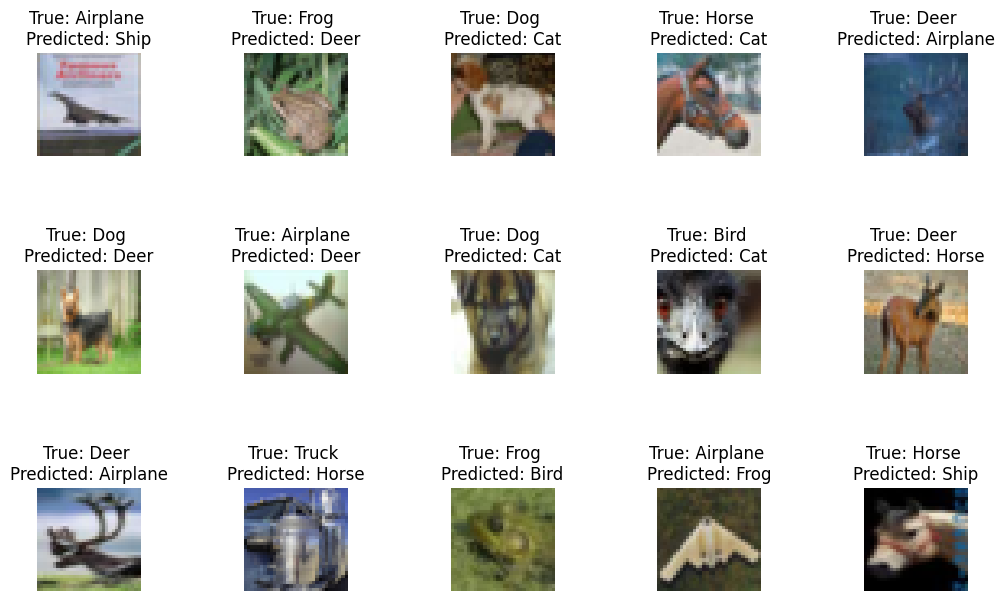

In [31]:
# Inspect errors
R = 3
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,8))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]],
                                                  labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

In [32]:
def show_test(number):
    fig = plt.figure(figsize = (3,3))
    test_image = np.expand_dims(x_test[number], axis=0)
    predict_x=model.predict(test_image)
    test_result=np.argmax(predict_x,axis=1)
    plt.imshow(x_test[number])
    dict_key = test_result[0]
    plt.title("Predicted: {} \nTrue Label: {}".format(labels[dict_key],
                                                      labels[Y_true[number]]))

1/1 [==============================] - 0s 153ms/step


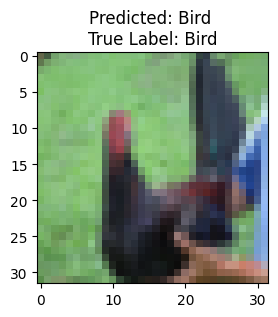

In [33]:
show_test(25)

## **PART 1** - *Your Turn*

### **Part 1 - Tasks:**

**1.1  &emsp;(*required*) - 10 points each**

 &emsp;**1.1.1** Is the dataset balanced?

 &emsp;**1.1.2** Does your model suffer from overfitting? If so, what would you suggest doing about it?

 &emsp;**1.1.3** Is accuracy a good metric of success in this case? Why (not)?

  &emsp;**1.1.4** What is the baseline accuracy for this dataset/problem?

**1.2 &emsp;(*optional*) - 15 bonus points**

 Write code to try different combinations of:

 - numbers of hidden layers and units per layer

 - loss functions

 - activation functions

 Please refrain from using better architectures (Vision Transformers, etc.) but feel free to use "advanced" techniques to curb overfitting (e.g., dropout, batch normalization, weight regularization, etc.)

#### **Part 1.1 - Required Tasks:**   *(responses)*

 **1.1.1**

   >Is the dataset balanced?

In this dataset, there are 10 classes, each containing 6,000 images. This means that each class has an equal number of samples, resulting in a balanced dataset in terms of class distribution. A balanced dataset is desirable for classification tasks as it ensures that the model has a similar number of examples to learn from for each class, avoiding biases towards any specific class during training.

The training set contains 50,000 images, which implies that each class has 5,000 samples in the training set. The test set consists of 10,000 images, with 1,000 images per class. This distribution also maintains the balance across classes.

In summary, the dataset is balanced, with an equal number of samples for each class. This balance helps in training and evaluating models for multi-label classification tasks.

In [35]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples\n')

# Count the number of classes in y_train and y_test
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)

# Print the number of classes and their counts
print("Training Set:")
for cls, count in zip(train_classes, train_counts):
    print(f"Class {cls}: {count} samples")

print("\nTesting Set:")
for cls, count in zip(test_classes, test_counts):
    print(f"Class {cls}: {count} samples")

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples

Training Set:
Class 0: 5000 samples
Class 1: 5000 samples
Class 2: 5000 samples
Class 3: 5000 samples
Class 4: 5000 samples
Class 5: 5000 samples
Class 6: 5000 samples
Class 7: 5000 samples
Class 8: 5000 samples
Class 9: 5000 samples

Testing Set:
Class 0: 1000 samples
Class 1: 1000 samples
Class 2: 1000 samples
Class 3: 1000 samples
Class 4: 1000 samples
Class 5: 1000 samples
Class 6: 1000 samples
Class 7: 1000 samples
Class 8: 1000 samples
Class 9: 1000 samples


 **1.1.2**
 > Does your model suffer from overfitting? If so, what would you suggest
doing about it?

No, the model doesn't suffer from overfitting because the model performs well on training data as well as with validation data.

Overfitting is a scenario where your model performs well on training data but performs poorly on data not seen during training. This basically means that your model has memorized the training data instead of learning the relationships between features and labels.

 **1.1.3**
 > Is accuracy a good metric of success in this case? Why (not)?

Yes, accuracy is a good metric of success in this case since we have balanced classes of data.

 **1.1.4**
 > What is the baseline accuracy for this dataset/problem?

For this dataset, a common baseline approach is to use a simple algorithm such as random guessing or majority class prediction. Since this dataset has 10 classes, the majority class baseline would involve predicting the most frequent class in the dataset for every input image.

Given that each class in the dataset contains 6,000 images out of the total 60,000, the majority class baseline would have an accuracy of approximately 10% (1/10). This is because randomly guessing or predicting the majority class for every image would result in getting the correct label 10% of the time on average.

It's important to note that the baseline accuracy is a basic reference point and should not be considered as a good or desirable performance. Complex machine learning models are expected to achieve significantly higher accuracies by learning meaningful patterns in the data and making accurate predictions beyond random guessing or majority class prediction.

#### **Part 1.2 - Optional Tasks:** *(responses & code)*

> Write code to try different combinations of:
- numbers of hidden layers and units per layer
- loss functions
- activation functions

>  Please refrain from using better architectures (Vision Transformers, etc.) but feel free to use "advanced" techniques to curb overfitting (e.g., dropout, batch normalization, weight regularization, etc.)

In [ ]:
# Your exploratory code here and in additional cells as needed


# **Part 2: Transfer Learning**

## **Part 2.1: Setup**

In [36]:
from keras import Sequential
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical

In [37]:
#Import dataset (again)
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

In [38]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [39]:
#Print the dimensions of the datasets to make sure everything's kosher

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [40]:
#One hot encode the labels.Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10

y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [41]:
# Lets print the dimensions one more time to see if things changed the way we expected

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


## **Part 2.2: Using ResNet50 as a base model**

Learn more about ResNet50 at: https://www.kaggle.com/keras/resnet50

In [42]:
base_model_1 = ResNet50(include_top=False,
                        weights='imagenet',
                        input_shape=(32,32,3),
                        classes=y_train.shape[1])

model_1=Sequential()
#Add the Dense layers along with activation and batch normalization
model_1.add(base_model_1)
model_1.add(Flatten())

#Add the Dense layers along with activation and batch normalization
model_1.add(Dense(4000,activation=('relu'),input_dim=512))
model_1.add(Dense(2000,activation=('relu')))
model_1.add(Dense(1000,activation=('relu')))
model_1.add(Dense(500,activation=('relu')))
model_1.add(Dense(10,activation=('softmax'))) #This is the classification layer

94765736/94765736 [==============================] - 3s 0us/step


In [64]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 4000)              8196000   
                                                                 
 dense_3 (Dense)             (None, 2000)              8002000   
                                                                 
 dense_4 (Dense)             (None, 1000)              2001000   
                                                                 
 dense_5 (Dense)             (None, 500)               500500    
                                                                 
 dense_6 (Dense)             (None, 10)               

In [43]:
batch_size= 128
epochs=10
learn_rate=.03

#don't know where this is being used
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate)

In [44]:
# Compile the model
model_1.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [45]:
# Train the model
history_1 = model_1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose = 1,
              validation_data=(x_val, y_val),
              shuffle=True)

Epoch 1/10
274/274 [==============================] - 31s 82ms/step - loss: 1.3246 - accuracy: 0.5453 - val_loss: 2.0029 - val_accuracy: 0.4577
Epoch 2/10
274/274 [==============================] - 19s 71ms/step - loss: 0.8275 - accuracy: 0.7227 - val_loss: 1.2103 - val_accuracy: 0.6170
Epoch 3/10
274/274 [==============================] - 19s 68ms/step - loss: 0.6531 - accuracy: 0.7819 - val_loss: 1.0132 - val_accuracy: 0.6738
Epoch 4/10
274/274 [==============================] - 19s 70ms/step - loss: 0.5335 - accuracy: 0.8222 - val_loss: 1.2357 - val_accuracy: 0.5883
Epoch 5/10
274/274 [==============================] - 19s 70ms/step - loss: 0.4471 - accuracy: 0.8516 - val_loss: 1.2872 - val_accuracy: 0.6364
Epoch 6/10
274/274 [==============================] - 19s 68ms/step - loss: 0.4485 - accuracy: 0.8503 - val_loss: 1.3531 - val_accuracy: 0.6245
Epoch 7/10
274/274 [==============================] - 23s 85ms/step - loss: 0.3237 - accuracy: 0.8921 - val_loss: 0.9719 - val_accuracy:

In [46]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(1,2,figsize=(10,5))
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history_1.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


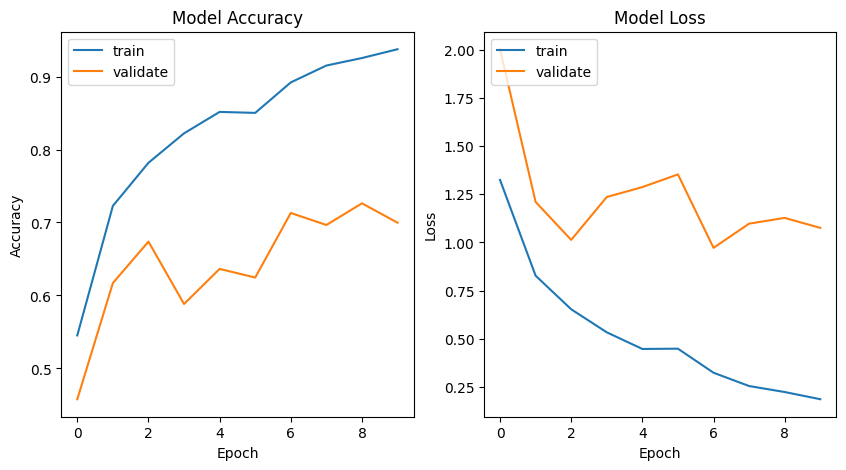

In [47]:
plotmodelhistory(history_1)

In [48]:
# Score trained model.
scores = model_1.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model_1.predict(x_test)

313/313 [==============================] - 6s 16ms/step - loss: 1.1066 - accuracy: 0.6920
Test loss: 1.1066374778747559
Test accuracy: 0.6919999718666077
313/313 [==============================] - 4s 9ms/step


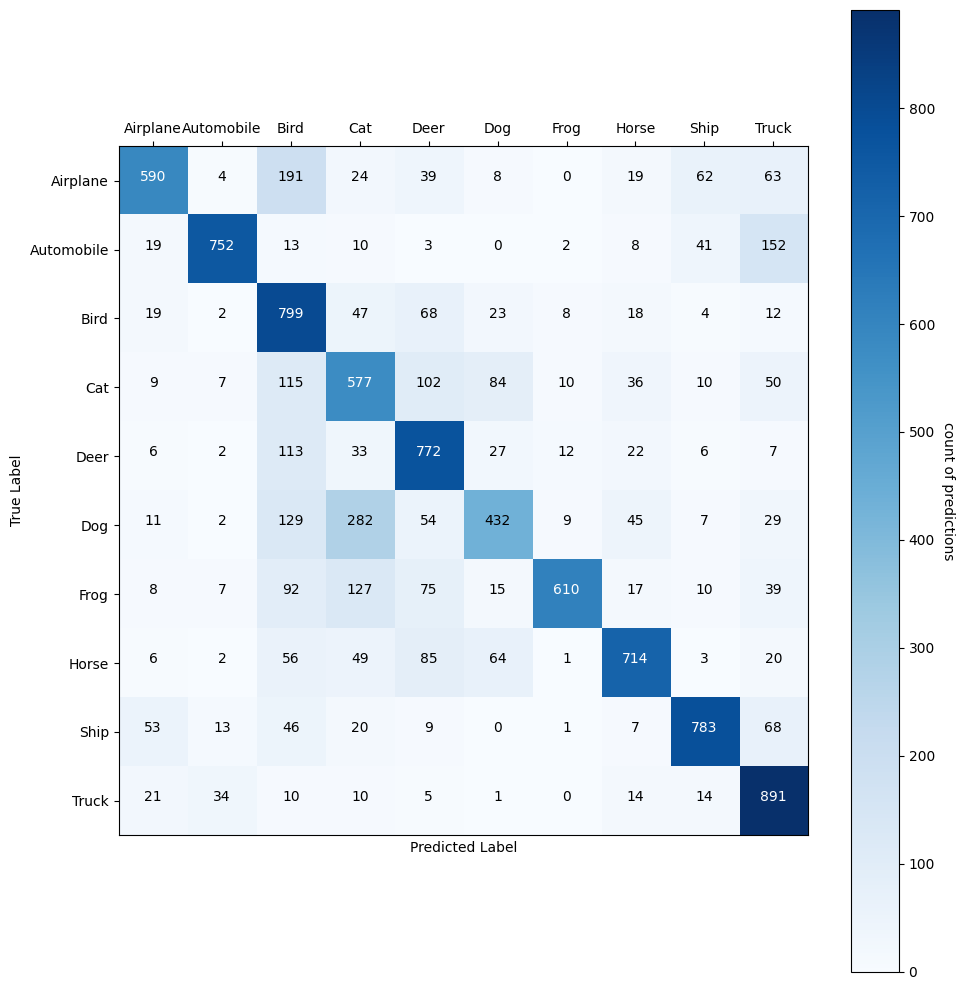

In [49]:
# Plot confusion matrix

# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes)
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(10,10))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

## **Part 2.3: Your turn!**

Write code to build, train, and evaluate *another* transfer learning model. (50 points)










### **Part 2.3.1: Tasks *(required)***

Write code to build, train, and evaluate *another* transfer learning model.

Here are a few things you could do:
*   Use a different base model, e.g., VGG19 (see https://www.kaggle.com/keras/vgg19)
*   Add Dropout layers
*   Use data augmentation
*   Change optimizer
*   Change other hyperparameters (learning rate, batch size, etc.)


***write your code in the code cell provided below***


### **Part 2.3.1: Your Code**

Please seperate models, if more than one are generated, with text cells containing something similar to the following

#### **Model 2 (some descriptor)**

additional models would have 3, 4, etc and unique descriptors.

#### **Model 2** *(double click to add some descriptor here)*

In [58]:
# Your code for Part 2.3.1 tasks here and in additional cells as needed for various models you examine

from tensorflow.keras.applications import VGG19

base_model_2 = VGG19(include_top=False,
                     weights='imagenet',
                     input_shape=(32, 32, 3))

base_model_2.summary()


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [59]:

model_2 = Sequential()
model_2.add(base_model_2)
model_2.add(Flatten())
# model_2.add(Dense(4000, activation='relu'))
# model_2.add(Dense(2000, activation='relu'))
# model_2.add(Dense(1000, activation='relu'))
# model_2.add(Dense(500, activation='relu'))
model_2.add(Dense(10, activation='softmax'))


In [60]:
model_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 4000)              2052000   
                                                                 
 dense_23 (Dense)            (None, 2000)              8002000   
                                                                 
 dense_24 (Dense)            (None, 1000)              2001000   
                                                                 
 dense_25 (Dense)            (None, 500)               500500    
                                                                 
 dense_26 (Dense)            (None, 10)               

In [63]:
batch_size= 128
epochs=10
learn_rate=.03
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate)

In [64]:
# Compile the model
model_2.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [65]:
# Train the model
history_2 = model_2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose = 1,
              validation_data=(x_val, y_val),
              shuffle=True)

Epoch 1/10
274/274 [==============================] - 21s 73ms/step - loss: nan - accuracy: 0.0992 - val_loss: nan - val_accuracy: 0.1021
Epoch 2/10
274/274 [==============================] - 19s 71ms/step - loss: nan - accuracy: 0.0991 - val_loss: nan - val_accuracy: 0.1021
Epoch 3/10
274/274 [==============================] - 20s 72ms/step - loss: nan - accuracy: 0.0991 - val_loss: nan - val_accuracy: 0.1021
Epoch 4/10
274/274 [==============================] - 20s 71ms/step - loss: nan - accuracy: 0.0991 - val_loss: nan - val_accuracy: 0.1021
Epoch 5/10
274/274 [==============================] - 20s 72ms/step - loss: nan - accuracy: 0.0991 - val_loss: nan - val_accuracy: 0.1021
Epoch 6/10
274/274 [==============================] - 20s 74ms/step - loss: nan - accuracy: 0.0991 - val_loss: nan - val_accuracy: 0.1021
Epoch 7/10
274/274 [==============================] - 20s 72ms/step - loss: nan - accuracy: 0.0991 - val_loss: nan - val_accuracy: 0.1021
Epoch 8/10
274/274 [==============

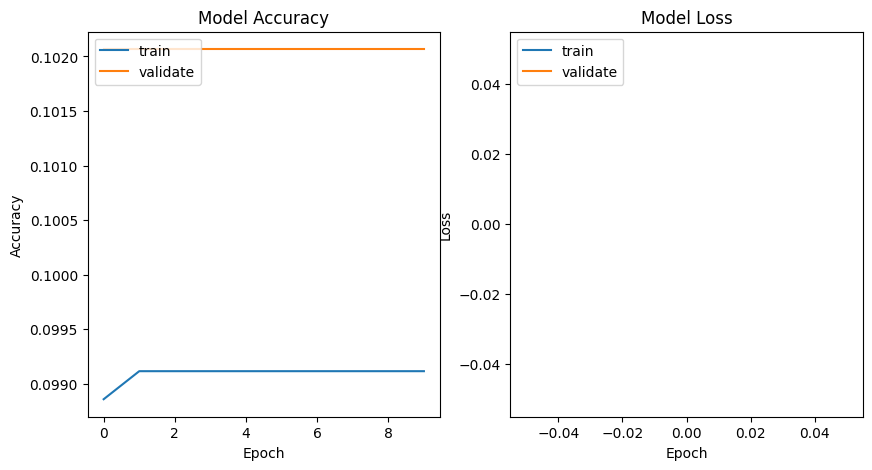

In [55]:
plotmodelhistory(history_2)

In [56]:
# Score trained model.
scores = model_2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model_2.predict(x_test)

313/313 [==============================] - 4s 11ms/step - loss: nan - accuracy: 0.1000
Test loss: nan
Test accuracy: 0.10000000149011612
313/313 [==============================] - 3s 8ms/step


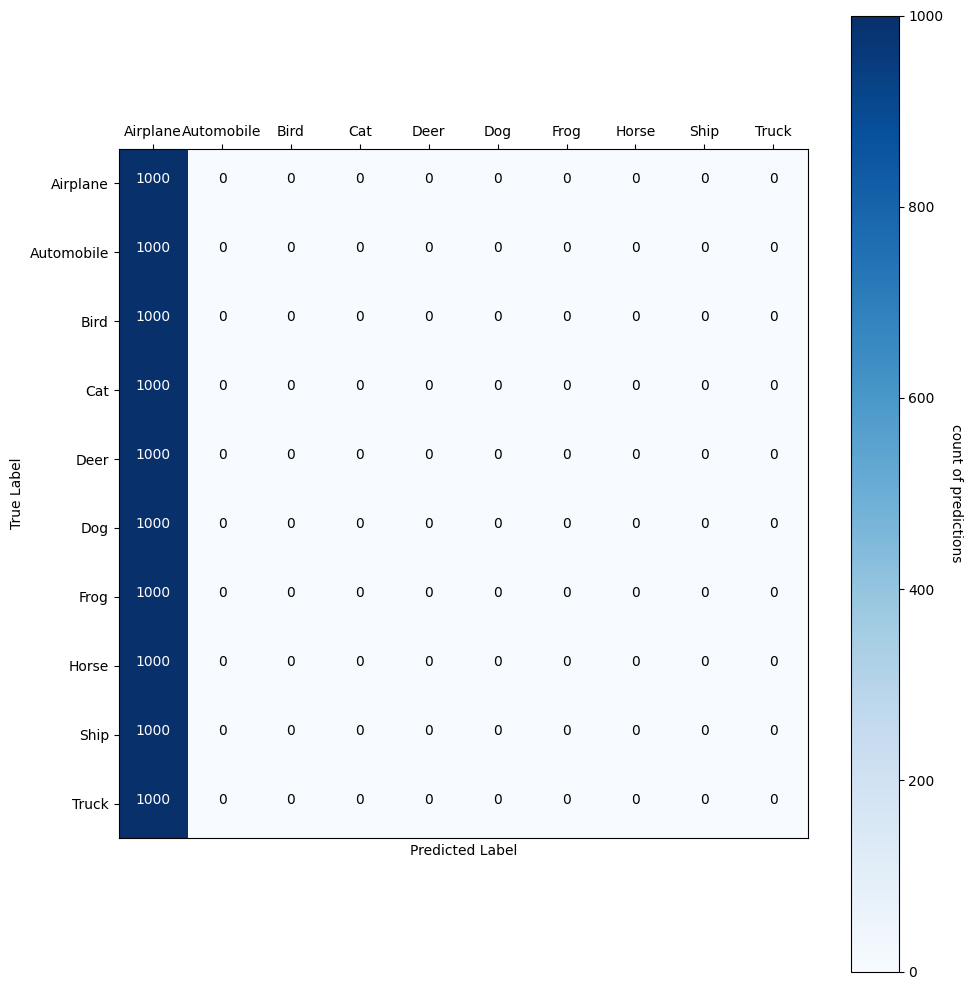

In [57]:
# Plot confusion matrix

# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes)
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(10,10))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

### Summary table of results
(all values and remarks are just _examples_) *(double click cell to edit)*

| Method | Test accuracy | Remarks |
| --- | --- | --- |
| (Part 1) Baseline CNN designed from scratch | 0.752 | Bad at telling cats from dogs |
| (Part 2 - Model 1) Transfer learning using pre-trained CNN (ResNet50) | 0.769| Disappointly low, signs of overfitting |
| (Part 2 - Model 2) Model / variation of your choice | 0.744| Disappointly low, signs of overfitting |
| (Part 2 - Model 3) Model / variation of your choice | 0.744| Disappointly low, signs of overfitting |


### Conclusions (10 points)

Write your conclusions here.